# Deep Learning - Lab 5
# Multiclass Image Classification using CNNs

------------------------------------------------


# Dataset
The given dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. **We will be using all of the 20,000 images**. The dataset in this assignment is going to be used on the following task:

## Given the pixels of an image, perform ethnicity classification for the image using a convolutional neural network.


The dataset for this lab is already cleaned and provided in a CSV format for you with images included as pixel values.

The 4 columns contain the following information:


* **[age]** is an integer from 0 to 116, indicating the age. You can convert it to float for regression predictions
* **[gender]** is either 0 (male) or 1 (female)
* **[race]** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
*  The 4th column contains the pixels of the images flattened to a single dimension. Each of the original image is of size 48x48 and the flattened image vector consists of 48x48 = 2304 pixel values.

## You would be only using the Ethnicity Labels for your task and discard the Age and Gender labels for this lab.

In [2]:
!gdown https://drive.google.com/file/d/1_KRWsOhQNf6BZcdu4pg2JVy-lHo7_Cno/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1_KRWsOhQNf6BZcdu4pg2JVy-lHo7_Cno
To: /content/DL_assignment1_dataset.csv
100% 199M/199M [00:01<00:00, 110MB/s]


In [3]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Lets use pandas to load our data
df = pandas.read_csv("/content/DL_assignment1_dataset.csv")
df

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...
23700,99,0,1,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,45 108 120 156 206 197 140 180 191 199 204 207...


### For this assignment we will be using convolutional neural networks and the full data set.

### Please do not change the seed for the sampling of data points.

Let us take a look at an image. You will get an idea of how to process your data for your neural network.

The 4th column contains all the pixel values in a string for each image. Lets convert all the strings to arrays first.

In [5]:
def string_to_array(pixel_string):
    pixel_list = pixel_string.split()
    pixel_array = np.array([int(value) for value in pixel_list])
    return pixel_array

In [6]:
df['pixels'] = df['pixels'].apply(string_to_array)

In [7]:
df['pixels']

0        [129, 128, 128, 126, 127, 130, 133, 135, 139, ...
1        [164, 74, 111, 168, 169, 171, 175, 182, 184, 1...
2        [67, 70, 71, 70, 69, 67, 70, 79, 90, 103, 116,...
3        [193, 197, 198, 200, 199, 200, 202, 203, 204, ...
4        [202, 205, 209, 210, 209, 209, 210, 211, 212, ...
                               ...                        
23700    [127, 100, 94, 81, 77, 77, 74, 99, 102, 98, 12...
23701    [23, 28, 32, 35, 42, 47, 68, 85, 98, 103, 113,...
23702    [59, 50, 37, 40, 34, 19, 30, 101, 156, 170, 17...
23703    [45, 108, 120, 156, 206, 197, 140, 180, 191, 1...
23704    [156, 161, 160, 165, 170, 173, 166, 177, 183, ...
Name: pixels, Length: 23705, dtype: object

Our "pixels" column has been converted to arrays which we can now use as input features to our model

Lets show the first image of our dataset

Age: 1
Ethnicity: 2
Gender: 0


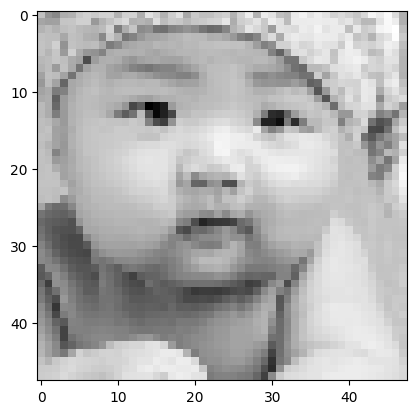

In [8]:
index = 31
first_image = df['pixels'][index]
image = first_image.reshape((48,48))
print("Age: "+str(df["age"][index])+"\nEthnicity: "+str(df["ethnicity"][index])+ "\nGender: "+str(df["gender"][index]))
plt.imshow(image,cmap="gray")

Uptill now, an initial processing has already been done using pandas in this starter code jupyter notebook. Hence you have a data frame ready for your assignment.

Please use the dataframe "df".

### You should consult the Lab 5 document provided to you for the tasks that are needed to be done for the successful completion of this lab. Grading rubricks are also mentioned in detail there.

# Note: In this lab you will be using all the 20,000 samples of this dataset.



In [61]:
# Write any further imports you need here
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

In [62]:
#### ---------------- CUDA GPU available ---------------- ####
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print ('CUDA available:', use_cuda)

CUDA available: True


________________________________
## Class definitions:
The following includes the Neural Network class, the Custom Dataset class to make use of PyTorch DataLoaders, as well as a Custom PyTorch style transformation to normalize the data

In [117]:
#### ---------------- neural network class ---------------- ####
class LabCNN_Classifier(nn.Module):
  def __init__(self, output_classes, input_channels=1):
    super(LabCNN_Classifier, self).__init__()

    self.conv_stack = nn.Sequential(
        nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.PReLU(num_parameters=1, init=0.25),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.PReLU(num_parameters=1, init=0.25),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.PReLU(num_parameters=1, init=0.25),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_stack = nn.Sequential(
        nn.Linear(128 * 6 * 6, 512),
        nn.BatchNorm1d(512),
        nn.PReLU(num_parameters=1, init=0.25),
        nn.Dropout(0.7),

        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.PReLU(num_parameters=1, init=0.25),
        nn.Dropout(0.5),

        nn.Linear(256, output_classes)
    )

  def forward(self, x):
    x = x.view(x.size(0), 1, 48, 48)
    x = self.conv_stack(x)
    x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
    logits = self.fc_stack(x)
    return logits


In [118]:
#### ---------------- dataset class for data loaders ---------------- ####

class LabDataset(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = {
              'age': self.data.iloc[idx, 0],
              'ethnicity': self.data.iloc[idx, 1],
              'gender': self.data.iloc[idx, 2],
              'pixels': self.data.iloc[idx, 3]
            }
    item = self.transform(item)
    return item

In [119]:
#### ---------------- custom pytorch transformation for data ---------------- ####
class Normalizer(object):
  def __call__(self, item):
    # 'item' contains an entry from the dataset
    pixels_norm = np.array(item['pixels'])
    pixels_norm = (pixels_norm - pixels_norm.min()) / (pixels_norm.max() - pixels_norm.min())
    return {
              'age': torch.tensor(item['age'], dtype=torch.float32),
              'ethnicity': torch.tensor(item['ethnicity'], dtype=torch.long),
              'gender': torch.tensor(item['gender'], dtype=torch.int),
              'pixels': torch.tensor(pixels_norm, dtype=torch.float32)
            }

________________________________________________________________________
## Module functions
The following are training, validation, and testing functions to follow the modular code requirement of the lab

In [120]:
# runs one epoch of training phase
def model_train(model, loss_func, optimizer, data_loader):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for batch in data_loader:
    # extract input and labels from the batch
    inputs = batch['pixels'].to(device)
    labels = batch['ethnicity'].to(device)

    # calculate initial predicted outputs & label (forward prop)
    optimizer.zero_grad()
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    # calculate loss using cross-entropy loss
    loss = loss_func(outputs, labels)

    # backward propagation
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # accuracy calc
    total += labels.size(0)
    correct += (predicted==labels).sum().item()

  # calculate acc and loss for training in one epoch and return it
  return {
              'Accuracy' : correct / total,
              'Loss' :  running_loss / len(train_loader),
          }

In [121]:
#### ---------------- validation and testing function ---------------- ####
# runs one epoch of validation phase
def model_val(model, loss_func, data_loader, testing=False):
  model.eval()
  running_loss = 0.0
  correct = 0
  all_labels = [] # saving labels and predicted so f1 score can be calculated with scikit
  all_predicted = []

  with torch.no_grad():
    for batch in data_loader:
      # extract input and labels from the batch
      inputs = batch['pixels'].to(device)
      labels = batch['ethnicity'].to(device)

      # predict labels based on provided inputs and calculate running_loss
      outputs = model(inputs)
      val_loss = loss_func(outputs, labels)
      running_loss += val_loss.item()

      # append labels and predicted labels for calculating f1 and acc
      _, predicted = torch.max(outputs, 1) # get actual predicted label
      correct += (predicted == labels).sum().item()
      all_labels += labels
      all_predicted += predicted


  all_labels = [tensor.cpu().numpy() for tensor in all_labels]
  all_predicted = [tensor.cpu().numpy() for tensor in all_predicted]
  num_batches = len(data_loader)

  metrics = {
              'Accuracy' : correct  /  len(all_labels),
              'Loss' : running_loss / num_batches,
              'F1 Score' : f1_score(all_labels, all_predicted, average='weighted'),
              'Confusion Matrix' : confusion_matrix(all_labels, all_predicted),
            }

  if testing is True:
    extra = {
              'Label' : all_labels,
              'Predicted' : all_predicted,
            }
    return metrics, extra # also return labels/predictions if it is testing phase

  return metrics # only return metrics for validation

In [122]:
#### ---------------- dictionary printing function ---------------- ####
# prints dictionaries nicely for the sake of ease of handling/displaying information
def print_dict(dictionary, breakpoint=4, spaces=2, testing=False):
  counter = 1
  for key, value in dictionary.items():
    # Only print confusion matrices if it is testing phase, not val
    if not testing and isinstance(value, (list, np.ndarray)):
        continue
    elif testing and isinstance(value, (list, np.ndarray)):
        print(f"\n\n{key}:\n{value}", end="\n")
        continue
    # Appropriate line spacing and line breaks
    formatted_value = f"{value:.4f}" if isinstance(value, float) else value
    separator = "  " if counter % breakpoint != 0 else "\n"

    print(f"{' ' * spaces}{key}: {formatted_value}", end=separator)
    counter += 1

  print("\n")

____________________________________________________
## Driver code
This includes the handling and splitting of datasets, creating all necessary steps to build and train a model, as well as displaying the results.

In [123]:
#### --------------------------- data handling --------------------------- ####

# splitting the dataset
train, temp_test = train_test_split(df, test_size=0.3, random_state=40)
test, val = train_test_split(temp_test, test_size=0.5, random_state=40)

print("Training data contains: ", len(train), " entries")
print("Validation data contains: ", len(val), " entries")
print("Testing data contains: ", len(test), " entries\n\n")

# converting to custom dataset classes:
transform = transforms.Compose([Normalizer()])
train_data = LabDataset(train, transform)
val_data = LabDataset(val, transform)
test_data = LabDataset(test, transform)

# data loaders
batch = 32
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch)

Training data contains:  16593  entries
Validation data contains:  3556  entries
Testing data contains:  3556  entries




In [124]:
print("Occurrences of each label:")
print(train['ethnicity'].value_counts())

Occurrences of each label:
0    7050
1    3188
3    2766
2    2392
4    1197
Name: ethnicity, dtype: int64


In [125]:
#### ---------------- creating model/loss_function/optimizer ---------------- ####

# model
input_size = len(train_data[0]['pixels']) # img size
output_classes = len(train['ethnicity'].unique()) # num of unique classes
model = LabCNN_Classifier(output_classes, input_channels=1)
model.to(device)

# loss function - specifying class weights in loss, since some classes have fewer entries than others
eth_vals = df['ethnicity'].values
class_weights = compute_class_weight('balanced', classes=np.unique(eth_vals), y=eth_vals)
ce_loss = nn.CrossEntropyLoss( weight=torch.tensor(class_weights, dtype=torch.float32).to(device) )


# optimizer - Adam
lr = 0.00003
optimizer = optim.Adam(model.parameters(), lr=lr)

In [126]:
#### ---------------- train and test the model ---------------- ####
epochs = 20

# lists for collecting plotting data
train_accs = []
train_losses = []
val_accs = []
val_losses = []
val_f1s = []

for epoch in range(epochs):

  # train and test the models, collect all returned values
  train_metrics = model_train(model, ce_loss, optimizer, train_loader)
  val_metrics = model_val(model, ce_loss, val_loader)

  # append to relevant arrays
  train_accs.append(train_metrics['Accuracy'])
  train_losses.append( train_metrics['Loss'])
  val_accs.append(val_metrics['Accuracy'])
  val_losses.append(val_metrics['Loss'])
  val_f1s.append(val_metrics['F1 Score'])

  print(f"Epoch {epoch+1}\n------------------------------------")
  print("Training Metrics: ")
  print_dict(train_metrics)
  print("Validation Metrics: ")
  print_dict(val_metrics)

Epoch 1
------------------------------------
Training Metrics: 
  Accuracy: 0.4311    Loss: 1.3909  

Validation Metrics: 
  Accuracy: 0.5734    Loss: 1.1416    F1 Score: 0.5764  

Epoch 2
------------------------------------
Training Metrics: 
  Accuracy: 0.5722    Loss: 1.1356  

Validation Metrics: 
  Accuracy: 0.6448    Loss: 0.9866    F1 Score: 0.6498  

Epoch 3
------------------------------------
Training Metrics: 
  Accuracy: 0.6334    Loss: 1.0046  

Validation Metrics: 
  Accuracy: 0.6777    Loss: 0.9173    F1 Score: 0.6840  

Epoch 4
------------------------------------
Training Metrics: 
  Accuracy: 0.6665    Loss: 0.9208  

Validation Metrics: 
  Accuracy: 0.6952    Loss: 0.8591    F1 Score: 0.7063  

Epoch 5
------------------------------------
Training Metrics: 
  Accuracy: 0.6900    Loss: 0.8618  

Validation Metrics: 
  Accuracy: 0.7148    Loss: 0.8366    F1 Score: 0.7223  

Epoch 6
------------------------------------
Training Metrics: 
  Accuracy: 0.7078    Loss: 0.8

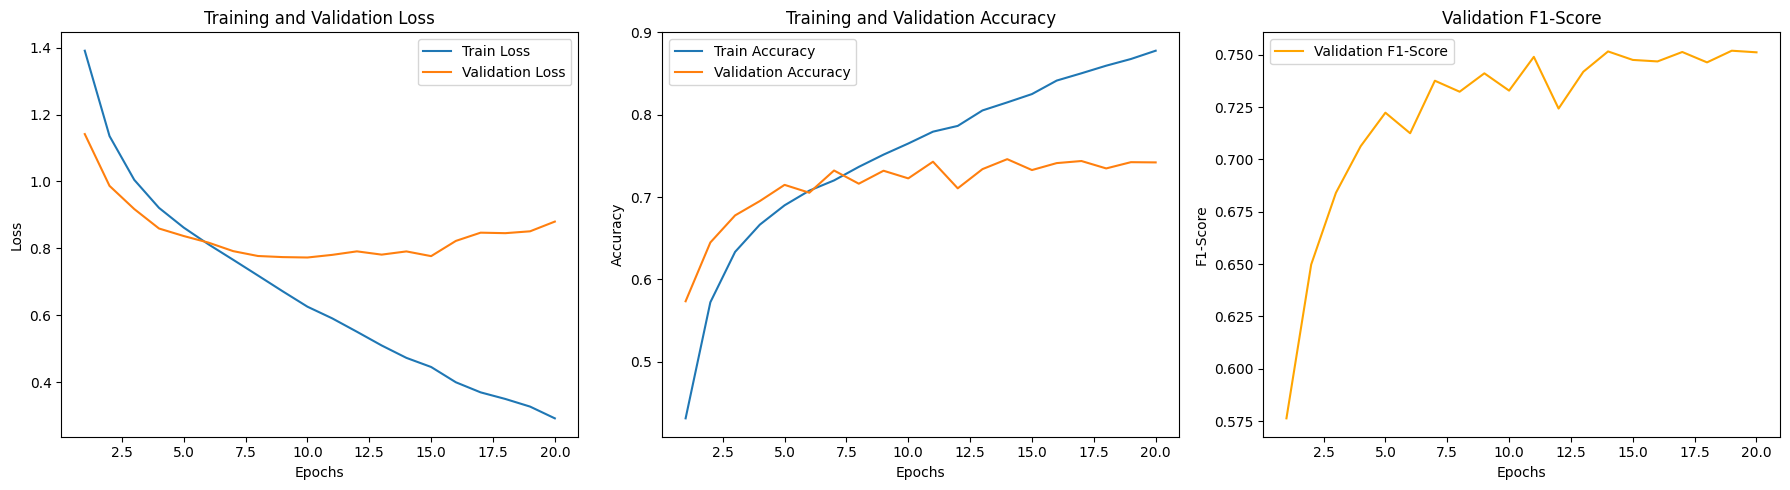

In [127]:
#### ---------------- plot the findings ---------------- ####

# using subplots
fig, axs = plt.subplots(1, 3, figsize=(18,5))
eps = range(1, epochs+1)

# val_loss and train_loss against each epoch
axs[0].plot(eps, train_losses, label='Train Loss')
axs[0].plot(eps, val_losses, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot val_acc and train_acc against each epoch
axs[1].plot(eps, train_accs, label='Train Accuracy')
axs[1].plot(eps, val_accs, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot val_f1 against each epoch
axs[2].plot(eps, val_f1s, label='Validation F1-Score', color='orange')
axs[2].set_title('Validation F1-Score')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('F1-Score')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [128]:
#### ---------------- final model testing ---------------- ####
test_metrics, results = model_val(model, ce_loss, test_loader, testing=True)

print("Final Model Performance:\n==========================================================\n")
print_dict(test_metrics, testing=True)
print("Sample Tests:\n==========================================================\n")

# print some sample tests
keys = list(results.keys())
values = list(results.values())
for i in range(len(values[0])):
    if i % 500 == 0:
      print(f"Sample Test #{i}:")
      counter = 0
      for key, value in zip(keys, values):
        counter += 1
        separator = ", " if counter % 3 != 0 else "\n"
        value[i] = value[i].item() if torch.is_tensor(value[i]) else value[i]
        print(f"{key}: {np.round(value[i])}", end=separator)
      print("\n")

Final Model Performance:

  Accuracy: 0.7565    Loss: 0.8684    F1 Score: 0.7625  

Confusion Matrix:
[[1151   59   88   92  121]
 [  20  548   17   33   40]
 [  31   11  455   17   22]
 [  51   35   29  441   48]
 [  55   24   25   48   95]]


Sample Tests:

Sample Test #0:
Label: 3, Predicted: 1, 

Sample Test #500:
Label: 0, Predicted: 0, 

Sample Test #1000:
Label: 0, Predicted: 0, 

Sample Test #1500:
Label: 3, Predicted: 3, 

Sample Test #2000:
Label: 0, Predicted: 3, 

Sample Test #2500:
Label: 1, Predicted: 1, 

Sample Test #3000:
Label: 3, Predicted: 3, 

Sample Test #3500:
Label: 1, Predicted: 1, 

